<a href="https://colab.research.google.com/github/mystlee/2024_CSU_AI/blob/main/chapter5/torch_autoencoder_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 모델 구성, 학습 등을 위한 라이브러리 import   
### torch   
  - pytorch 프레임워크   

### torch.nn
  - nn = neural network   
  - 딥러닝 관련 라이브러리  
  - fully-connected layer, conv layer 등을 포함  

### torchvision   
  - torch에서 제공하는 image 처리 특화 라이브러리

### torch.optim
  - 모델 학습을 위한 옵티마이저 라이브러리   
  - SGD, AdaGrad, RMSProp, Adam 등 옵티마이저 포함

### torch.utils.data
  - torch에서 제공하는 dataset 다운로드 및 관리 패키지   

### sklearn.manifold
  - 시각화를 위한 t-SNE


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## 1. 데이터셋 구성   
MNIST 데이터를 load 한 뒤, data loader로 변환   

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data',
                               train = True,
                               download = True,
                               transform = transform)
train_loader = DataLoader(train_dataset,
                          batch_size = 128,
                          shuffle = True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.14MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 2. 모델 구조   
### 모델 구조 작성   
- 일반적으로 class 의 \_\_init\_\_ 함수부분에서 모듈들은 선언하고,
- 그 다음 forward 함수에 전체적인 흐름 작성   
- 단순한 encoder-decoder 구조

<img src = "https://blog.kakaocdn.net/dn/cDCfoH/btr16iLsgIV/ObKRKrnxL8b0a1QgxJElK1/img.png" width = "80%" height = "70%">   

출처: <https://bkshin.tistory.com/entry/%EC%BB%B4%ED%93%A8%ED%84%B0-%EB%B9%84%EC%A0%84-7-%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94AutoEncoder%EC%99%80-%EB%A7%A4%EB%8B%88%ED%8F%B4%EB%93%9C-%ED%95%99%EC%8A%B5Manifold-Learning>   

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


## 3. 손실 함수 및 옵티마이저 정의 및 학습
- batch 단위로 update 진행
- error와 gradients를 계산하고 업데이트!
- regression task -> MSE loss를 사용!
- optimizer는 Adam 사용
- 학습 함수는 간단하여 별도 함수를 작성하지 않음



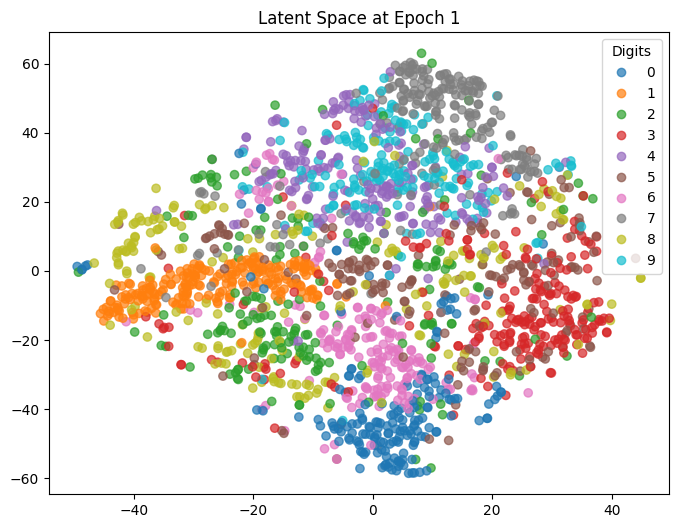

Epoch [1/10], Loss: 0.0241


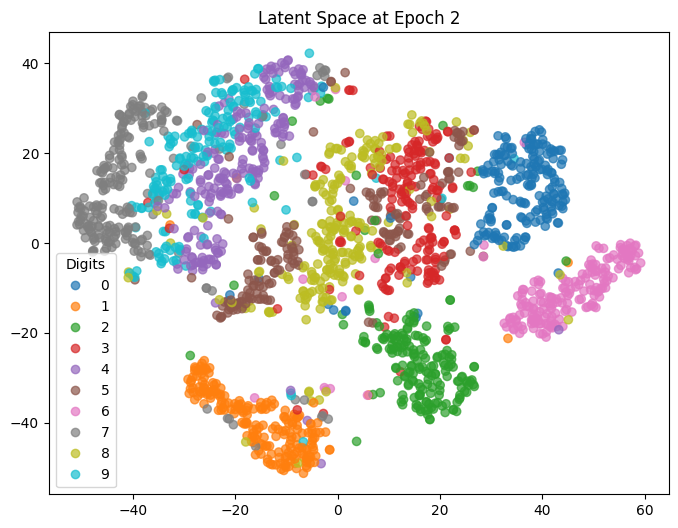

Epoch [2/10], Loss: 0.0180


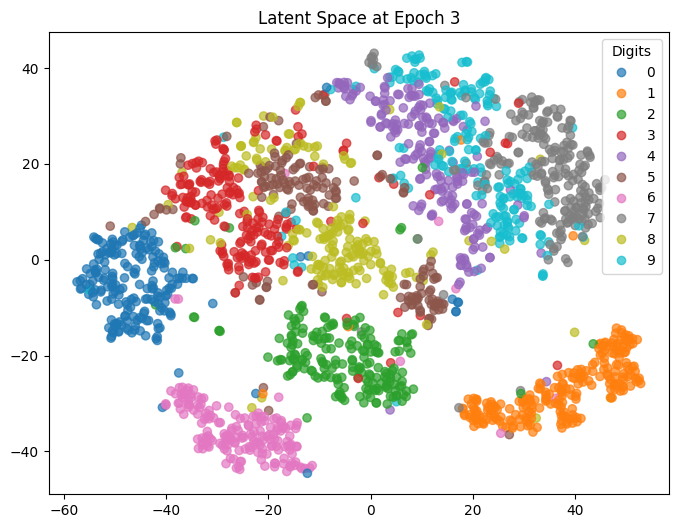

Epoch [3/10], Loss: 0.0144


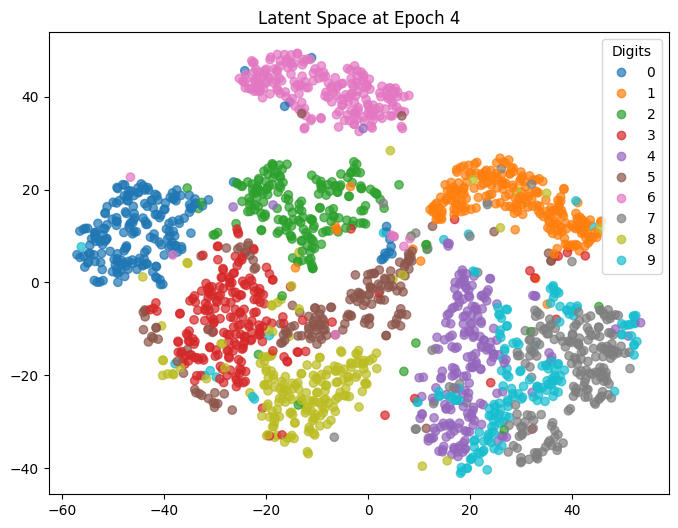

Epoch [4/10], Loss: 0.0123


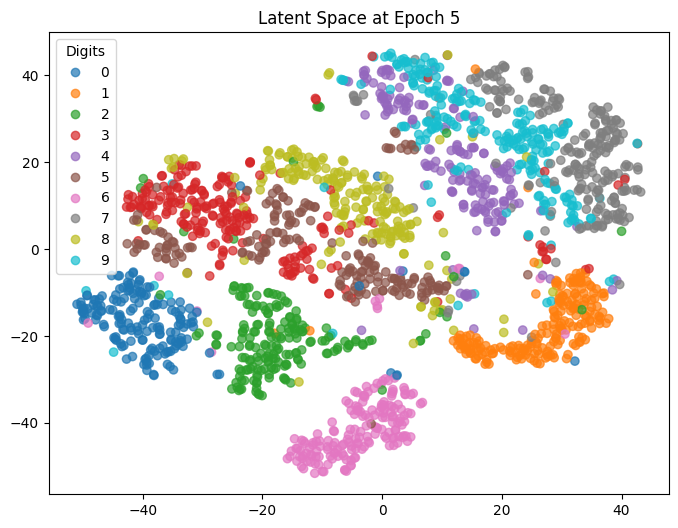

Epoch [5/10], Loss: 0.0093


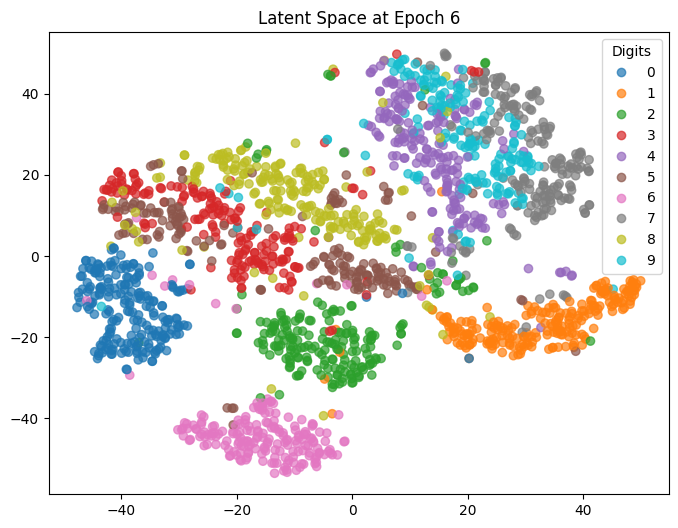

Epoch [6/10], Loss: 0.0098


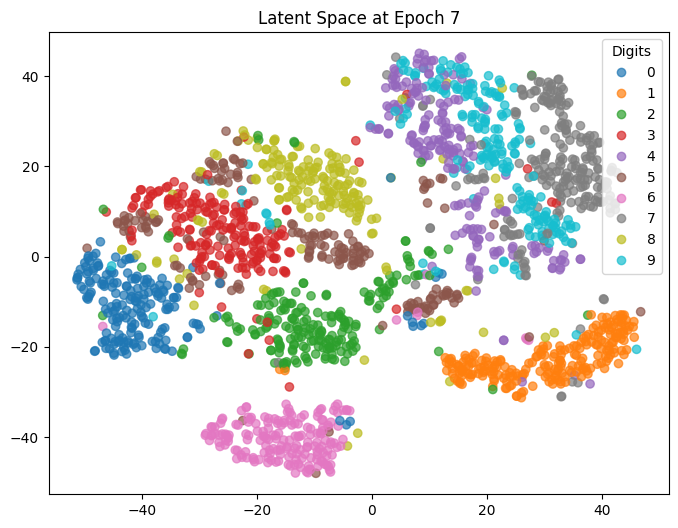

Epoch [7/10], Loss: 0.0099


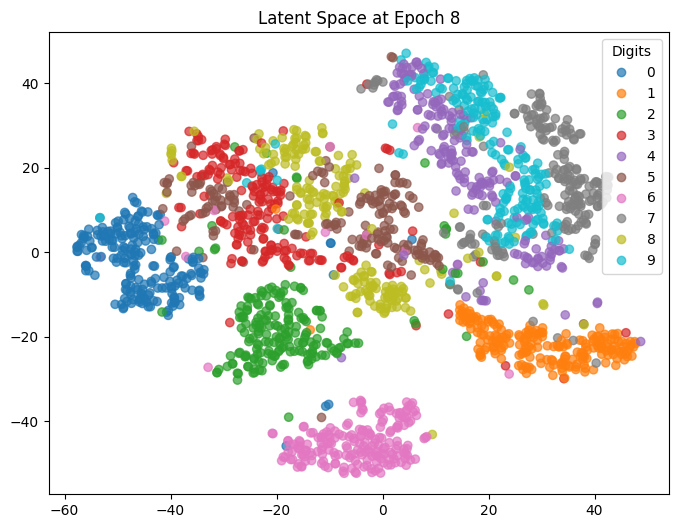

Epoch [8/10], Loss: 0.0083


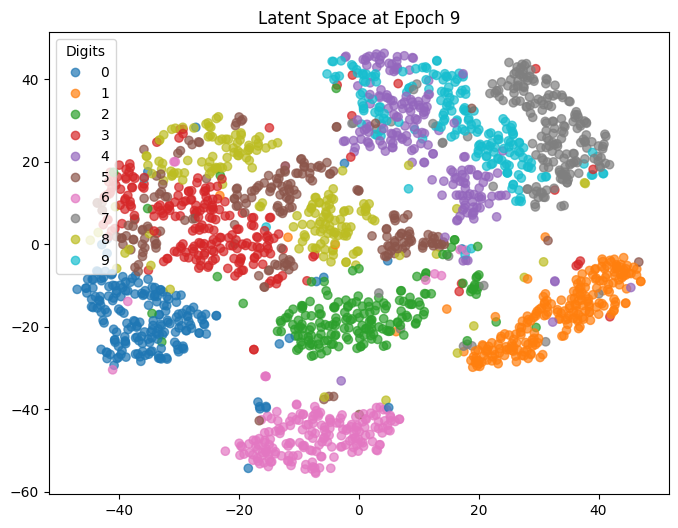

Epoch [9/10], Loss: 0.0091


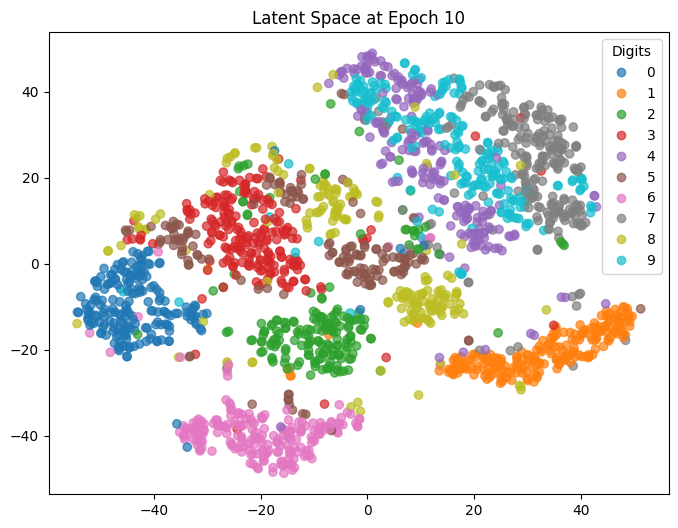

Epoch [10/10], Loss: 0.0081


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder(latent_dim = 32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    model.eval()
    latent_vectors = []
    labels = []
    sample_size = 2000
    indices = np.random.choice(len(train_dataset), sample_size, replace = False)
    sampled_dataset = Subset(train_dataset, indices)
    sampled_loader = DataLoader(sampled_dataset, batch_size = 128, shuffle=False)

    with torch.no_grad():
        for data, target in sampled_loader:
            data = data.to(device)
            _, z = model(data)
            latent_vectors.append(z.cpu().numpy())
            labels.append(target.numpy())

    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)

    # t-SNE 적용
    tsne = TSNE(n_components=2, random_state=0)
    latent_tsne = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c = labels, cmap = 'tab10', alpha = 0.7)
    plt.legend(*scatter.legend_elements(), title = "Digits")
    plt.title(f'Latent Space at Epoch {epoch+1}')
    plt.show()


    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, z = model(data)
        loss = criterion(recon_batch, data)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



## * 시각화
Auto-encoder에서 encoder의 output을 이용한 시각화   
latent space에서 서로 같은 class끼리는 잘 뭉치고, 다른 class끼리 잘 떨어진다?   
-> 숫자를 잘 표현할 수 있다라고 해석할 수 있음